# API Mashup: Judging Books by their Covers

I'd like to write a short program to find the cover for a given book title, and run it through the Google Cloud Vision API, which will try to guess labels for the cover image.

First, import all the libraries we'll need:

In [22]:
# For making API requests
import requests

# For parsing JSON responses
import json

# For displaying images in a Jupyter notebook
from IPython.display import Image

# For interacting with the Google Cloud Vision API
from google.cloud import vision
from google.cloud.vision import types

# For setting environment variables.
import os

Next, the [Google API authentication instructions](https://cloud.google.com/vision/docs/libraries) say to set the [environment variable](https://en.wikipedia.org/wiki/Environment_variable) to the location of the JSON file for your API keys. (This is a JSON file that you can download from Google once you sign up for API access.) 

In [27]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/jon/google-creds.json'

Let's try to get the ISBN for Frank Herbert's _Dune_. First, make the request to the Open Library API. 

In [188]:
params = {'title': 'Dune', 'author': 'Frank Herbert'}
response = requests.get('http://openlibrary.org/search.json', params=params)

Make sure the response came back OK:

In [189]:
response.ok

True

Parse the response using our JSON library.

In [190]:
parsed = json.loads(response.text)

In [191]:
isbn = parsed['docs'][3]['isbn'][0]
isbn

'0881036366'

Next, look up the cover. The Open Library covers API tells us to construct the URL like this: 

`http://covers.openlibrary.org/b/$key/$value-$size.jpg` 

where `$key` is something like "ISBN", `$value` is the ISBN, and `$size` is one of `S`, `M`, or `L`.

In [192]:
coverURL = 'http://covers.openlibrary.org/b/ISBN/' + isbn + '-L.jpg'

Let's use Jupyter to try to display this image here.

In [193]:
Image(url=coverURL)

We have to save this image to our disk, since for some reason Google can't get this image directly from the source, but needs to read it from our box instead. 

In [194]:
coverResponse = requests.get(coverURL, stream=True)
with open('cover.jpg', 'wb') as f:
    f.write(coverResponse.content)

Now feed it to the Google Cloud Vision API. I'll make this a little bit easier by using the pre-made Google Cloud Vision client, or library. (I installed this on my computer by running `sudo pip3 install google-cloud-vision`. Here I'm using code adapted from the example at https://cloud.google.com/vision/docs/detecting-labels#vision-label-detection-python.


In [196]:
client = vision.ImageAnnotatorClient()

content = open('cover.jpg', 'rb').read()
image = types.Image(content=content)

response = client.label_detection(image=image)
labels = response.label_annotations
print('Labels:')

for label in labels:
    print(label.description)

Labels:
poster
ecoregion
landscape
font
advertising


"ecoregion" sounds interesting! 

## Let's try it again, with another book!

Only now we'll wrap this in a function, so it'll be easy to run it multiple times with different inputs.

In [247]:
def judgeBookByCover(title, author):
    params = {'title': title, 'author': author}
    response = requests.get('http://openlibrary.org/search.json', params=params)
    if response.ok:
        parsed = json.loads(response.text)
        if len(parsed['docs']) > 0:
            if len(parsed['docs'][0]['isbn']) > 0:
                isbn = parsed['docs'][0]['isbn'][0]
            else:
                raise Exception("Can't find isbn.")
        else:
            raise Exception("Can't find book.")
        coverURL = 'http://covers.openlibrary.org/b/ISBN/' + isbn + '-L.jpg'
        coverResponse = requests.get(coverURL, stream=True)
        if coverResponse.ok:
            with open('cover.jpg', 'wb') as f:
                f.write(coverResponse.content)
            client = vision.ImageAnnotatorClient()
            content = open('cover.jpg', 'rb').read()
            image = types.Image(content=content)
            response = client.label_detection(image=image)
            labels = response.label_annotations
            print('Judgements:')
            for label in labels:
                print(label.description)
        else:
            raise Exception("Can't find cover.")
    else: 
        raise Exception("Bad response from initial book search.")


In [245]:
judgeBookByCover('The Princess Bride', 'William Goldman')

Judgements:
poster
mythical creature
film
mythology
fiction
fictional character
book


In [246]:
Image(url=coverURL)

In [243]:
judgeBookByCover('Great Gatsby', 'Fitzgerald')

Judgements:
poster
film
tourism
advertising


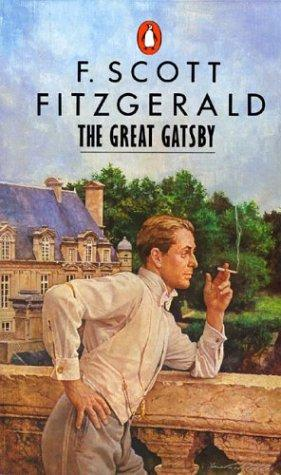

In [244]:
Image(filename='cover.jpg')

In [241]:
judgeBookByCover('Twilight', 'Stephanie Meyer')

Judgements:
love
hand
poster
still life photography
fruit
finger
produce
font
hand model
photo caption


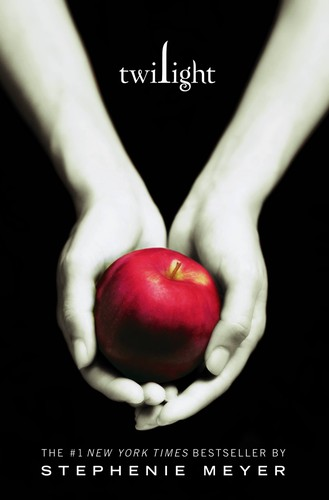

In [242]:
Image(filename='cover.jpg')

# Conclusion

This doesn't work very well. So, don't judge a book by its cover!